# Applied Data Science Capstone

## Introduction

<b>TL;DR; Going to find out what restaurant to open that best serves police stations, and which station(s) will benefit the most.</b>

A description of the problem and a discussion of the background. (15 marks)
A description of the data and how it will be used to solve the problem. (15 marks)

### Problem Description

The purpose of this project is to find the best place for an associated business. For example, around a hospital you will most likely find pharmacies, or a Pawn shop and a Casino. Now we may think that police officers love donuts, so donut shops may be clustered around police stations. Is this true or just a stereotype? This project we will identify the most common restaurants around police stations in a particular city, then we will determine which type of restaurant around a particular police station that someone should open.

#### Why do I want to do this?

Intellectual curiosity on my part, but it does have some important impacts for others. First, it gives someone an opportunity to choose the best business to support an organization that they love. For me that would be to support local law enforcement. 

#### Why is this important, and who would be interested?

Someone who wants to support an organization, but still open a successful business would be interested in the results of this project. For example, you might be a retired police officer in a new city. You may have your own opinions on what is best, but this city is different. The data provided by this project would give you a greater chance of success while still supporting the law enforcement community that you love. 

As a side benefit of interest to anyone, this can support or discredit stereotypes. 



## Data

<b>TL;DR; Get locations of police stations, Find closest businesses, cluster, find most common, apply suggestion to least common. </b>

I am anticipating that most if not all data will be coming from Foursquare. This section is broken down into two parts, Gathering Data, Working with Data.


### Gathering Data

We need to start somewhere, so seeing that our target audience is someone retiring from the industry, and Florida is a great place to retire, we will be using Orlando, Florida as our test market. However, we can use the data from any city and apply the same analysis. If this was a web-based tool, we would let the user select the location, and category that they would like to support, however this is a class assignment so I am choosing Police and Orlando Florida.

#### Get the locations of Police Stations and Filter as needed

Lucky for us, Foursquare has categorized venues, and Police Stations is one of the categories! (https://developer.foursquare.com/docs/build-with-foursquare/categories/) 
<b><br>Police Station</b><br>
<b>4bf58dd8d48988d12e941735</b>

To get the police stations in Orlando Florida, we will use the venue search API call with the appropriate category ID (https://developer.foursquare.com/docs/api-reference/venues/search/)

The call is a nested structure and we do not know if they want a category or end node, therefore we will have to flatten the table.


#### Get nearby Venue Data

<code> https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={} </code>

We will then gather and filter nearby venues. This includes location data so we will be using folium to map the data.


#### Analyze the areas surrounding the user defined category

Get the most common businesses for each area surrounding the user defined category, in our case police stations.

#### Cluster the data

use k-means to cluster by popularity. This lets us know what the categories are for popularity. 

### Find the most underserved area to recommend to our end user

Which police station ranks last? that is most likely the best location for opening up the top item(s) from the ranking.

We can also answer the stereotype problem. Let us see if donut shops rank #1.


# Code

This point forward is a work in progress

Any Sensitive data is in the following protected cell, This includes API keys

In [1]:
# The code was removed by Watson Studio for sharing.

### Import any neccesary libraries

In [2]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

#Install geopy
#already installed, remove coment if needed
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('geopy installed')

#install folium
#already installed, remove coment if needed
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium

import folium # map rendering library
print('folium installed')


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import json # library to handle JSON files

from pandas.io.json import json_normalize #package for flattening json in pandas df

from folium.features import DivIcon

print('Libraries imported.')

geopy installed
folium installed
Libraries imported.


### <b>What we are seraching for. This can be convereted to user input for future versions</b>

In [3]:
where_do_you_want_to_be = 'Orlando, Florida'
which_category_do_you_want_to_support = "Police Station"

print('Our end user wants to be in {}, and support {}.'.format(where_do_you_want_to_be, which_category_do_you_want_to_support))

Our end user wants to be in Orlando, Florida, and support Police Station.


#### Get lat/long of the location of where our user wants to be.

In [4]:
address = where_do_you_want_to_be

geolocator = Nominatim(user_agent="location_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Orlando, Florida are 28.5421109, -81.3790304.


#### Get the category ID for the category the user wants to support

To do this we will need to get the proper category, then get a dataset containing all all of the location names and locations for that category. (we may limit the amount due to non-paid API call limitations)

In [5]:
# https://developer.foursquare.com/docs/api-reference/venues/categories/

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

# make the GET request
results = requests.get(url).json()["response"]



We now have the category information. It turns out that it is a nested structure, we want to flatten it. We do not know if our end user wants it for a whole category or just a particualr end node

So, we are going to use a recursive function to flatten the data.

In [6]:
# https://towardsdatascience.com/how-to-flatten-deeply-nested-json-objects-in-non-recursive-elegant-python-55f96533103d

def flatten_json_same_nested_category(nested_json):
    """
        Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    ret = {}

    def flatten(df1, ret):
        if 'name' in df1.columns:
            #print(df1)
            ret = ret.append(df1[['id', 'name', 'pluralName', 'shortName']], ignore_index=True)
            #print('ssssssssssssssss')
            
        for row in df1.itertuples(index=False):         
            if len(row[0]) > 0:
                for item in row[0]:
                    x = pd.DataFrame.from_dict(json_normalize(item["categories"]))
                    ret = pd.DataFrame.from_dict(json_normalize(item))[['id', 'name', 'pluralName', 'shortName']].append(ret, ignore_index=True)
                    ret = flatten(x, ret)
                    
        return ret

    df1 = pd.DataFrame.from_dict(json_normalize(nested_json["categories"])[['categories']])
    ret = pd.DataFrame.from_dict(json_normalize(nested_json["categories"])[['id', 'name', 'pluralName', 'shortName']])
    
    ret = flatten(df1, ret)
    return ret

Now that we have our function, let's uses it.

In [7]:
df_categories = flatten_json_same_nested_category(results)

print('Lots of categories Labels, {}!  Shape = {}   note: the first column is the ID so it is the = (# of rows * (# columns -1))'.format(df_categories.shape[0]*(df_categories.shape[1]-1), df_categories.shape))
print('Sample the frist 5 rows:')
df_categories.head(5)

Lots of categories Labels, 2829!  Shape = (943, 4)   note: the first column is the ID so it is the = (# of rows * (# columns -1))
Sample the frist 5 rows:


,id,name,pluralName,shortName
0,52f2ab2ebcbc57f1066b8b4a,Tunnel,Tunnels,Tunnel
1,4f04b25d2fb6e1c99f3db0c0,Travel Lounge,Travel Lounges,Lounge
2,54541b70498ea6ccd0204bff,Transportation Service,Transportation Services,Transportation Services
3,52f2ab2ebcbc57f1066b8b51,Tram Station,Tram Stations,Tram
4,4bf58dd8d48988d129951735,Train Station,Train Stations,Train Station


Great! Our dataframe looks good, now let's find the category our user wants.

In [8]:
print('We are searching for the {} category'.format(which_category_do_you_want_to_support))

df_categories.loc[df_categories['name'] == which_category_do_you_want_to_support].dropna(how='all')

We are searching for the Police Station category


,id,name,pluralName,shortName
839,4bf58dd8d48988d12e941735,Police Station,Police Stations,Police Station


#### We now have our Category and the Category ID For our end user

In [9]:
category_id = df_categories.loc[df_categories['name'] == which_category_do_you_want_to_support].dropna(how='all').iloc[0,0]

print('The category ID for "{}" is {}'.format(which_category_do_you_want_to_support, category_id))

The category ID for "Police Station" is 4bf58dd8d48988d12e941735


#### Now Lets Find the location for each police station

We are going to need to find all items in the selected category within the selected city. What we want to get is a buisness name, and appropriate location.

First we need to get the data from Foursquare:

https://developer.foursquare.com/docs/api-reference/venues/search/

In [10]:
# No need to specify radius, the default is citywide, which is what we want. 
# query	tacos	A search term to be applied against venue names.
# We are hard coding a limit of 50 as to limit API calls due to free limits per day.

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&limit=50'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            where_do_you_want_to_be,
            category_id
            )

# make the GET request
results_category_places = requests.get(url).json()["response"]["venues"]

In [11]:

        
# return only relevant information
category_places_exract=[]
category_places_exract.append([(
            item['id'], 
            item['name'], 
            item['location']['lat'], 
            item['location']['lng']) for item in results_category_places])

category_places = pd.DataFrame([item for category_places_exract in category_places_exract for item in category_places_exract])
category_places.columns = ['id', 
                         'name',
                         'Latitude',
                         'Longitude']

print('There are {} locations related to "{}" in {}'.format(category_places.shape[0],which_category_do_you_want_to_support, location))
category_places.head(5)
        

There are 48 locations related to "Police Station" in Orlando, Orange County, Florida, United States of America


,id,name,Latitude,Longitude
0,4e8af7930aaf72bf6351b5a4,Center For Colon & Rectal Surgery,28.526626,-81.380094
1,517ea93ae4b028cbb2352ca1,Orange County Corrections South Perimeter,28.501917,-81.415222
2,51578602e4b00a2d60a1caad,Orange County Corrections North Perimeter,28.506629,-81.415022
3,51af6d83498e22dec3f9271d,Clermont Police Dept,28.587144,-81.682931
4,4e5d44ddd4c07641360b836a,Security Office,28.378806,-81.547133


In [12]:
location

Location(Orlando, Orange County, Florida, United States of America, (28.5421109, -81.3790304, 0.0))

OK, let's see what it looks like on a map, then decide if it is too crowded, or we should filter on just boroughs with "Toronto" in the name

In [13]:
latitude

28.5421109

In [14]:
longitude

-81.3790304

In [15]:
# create map using latitude and longitude values

map_loc = folium.Map(location=[latitude, longitude], zoom_start=8, width=500,height=500)

# add markers to map
for lat, lng, name, ident in zip(category_places['Latitude'], category_places['Longitude'], category_places['name'], category_places['id']):
    label = '{}, {}'.format(name, ident)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_loc)  


#### We don't know in advance the city size, so we should find the best fit based on the data retrieved

In [16]:
#map_loc
sw = category_places[['Latitude', 'Longitude']].min().values.tolist()
ne = category_places[['Latitude', 'Longitude']].max().values.tolist()

map_loc.fit_bounds([sw, ne]) 
map_loc

Now we have an issue. We need to cluster the locations together, but we do not have any neighborhood data. We could get data for this city, but that would be a manual process and unique to the city. We need to do this for any city that a user could enter. So now we need to automatically create areas.

https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

##### Great map, lets see if we can cluster things togeter

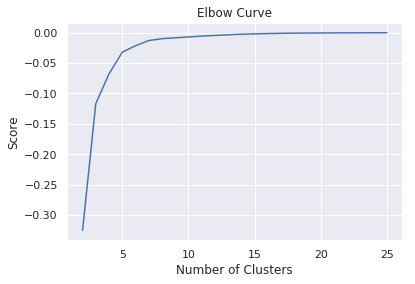

In [17]:
kmax = 25
K_clusters = range(2, kmax+1)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = category_places[['Latitude']]
X_axis = category_places[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

##### 

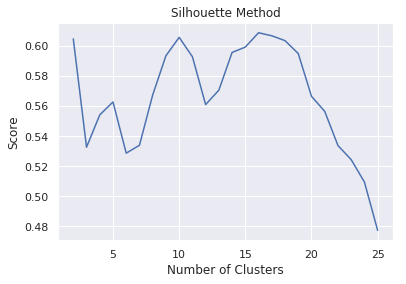

Our max is 16, We will use this number for KMeans for this run.


In [18]:
score

from sklearn.metrics import silhouette_score

list_silhouette = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X_axis)
    labels = kmeans.labels_
    list_silhouette.append(silhouette_score(X_axis, labels, metric = 'euclidean'))

plt.plot(K_clusters, list_silhouette)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Method')
plt.show()


silhouette_max_value = max(list_silhouette)
silhouette_max_index = list_silhouette.index(silhouette_max_value) + 2

print('Our max is {}, We will use this number for KMeans for this run.'.format(silhouette_max_index))



##### We found our optial cluster number

In [19]:
optimal_number_of_clusters = silhouette_max_index
print('optimal_number_of_clusters = {}'.format(silhouette_max_index))

optimal_number_of_clusters = 16


In [20]:
kmeans = KMeans(n_clusters = optimal_number_of_clusters, init ='k-means++')
kmeans.fit(category_places[category_places.columns[2:4]]) # Compute k-means clustering.
category_places['cluster_label'] = kmeans.fit_predict(category_places[category_places.columns[2:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(category_places[category_places.columns[2:4]]) # Labels of each point
category_places.head(10)

,id,name,Latitude,Longitude,cluster_label
0,4e8af7930aaf72bf6351b5a4,Center For Colon & Rectal Surgery,28.526626,-81.380094,14
1,517ea93ae4b028cbb2352ca1,Orange County Corrections South Perimeter,28.501917,-81.415222,1
2,51578602e4b00a2d60a1caad,Orange County Corrections North Perimeter,28.506629,-81.415022,1
3,51af6d83498e22dec3f9271d,Clermont Police Dept,28.587144,-81.682931,9
4,4e5d44ddd4c07641360b836a,Security Office,28.378806,-81.547133,4
5,4cc9963241e7548101565d84,Sanford Police/Fire Dept Headquarters,28.800351,-81.276878,0
6,5060e705e4b019bb6a7b31f2,Osceola County Emergency Operations Center,28.277358,-81.337378,2
7,5a391575e2d4aa6babe1cf60,Orlando Police Department,28.537717,-81.396592,14
8,4d55183dba5b224b383d0a14,Sheriff's North Orange Substa,28.700003,-81.508221,13
9,5681a7e8498ec0defa892b85,Orange County Sheriff's Office Substation 5,28.412741,-81.472453,12


##### Graph the cluster as a sanity check

In [21]:


# set color scheme for the clusters
colors_array = cm.gist_ncar(np.linspace(0, 1, optimal_number_of_clusters))
cluster_to_color = [colors.rgb2hex(i) for i in colors_array]


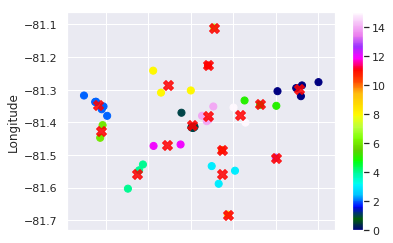

In [22]:
category_places.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='gist_ncar')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.85, marker="X")

Looks great, now we should put that on a map 

In [23]:
map_loc = folium.Map(width=750,height=600, location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, name, ident, cluster in zip(category_places['Latitude'], category_places['Longitude'], category_places['name'], category_places['id'], category_places['cluster_label']):
    label = '{}, {}'.format(name, ident)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color=cluster_to_color[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_loc)  

df_centers = pd.DataFrame(centers, columns=["Latitude", "Longitude"])
df_centers['Cluster'] = range(0,len(df_centers)) 
    
# Add Centers to map
for lat, lng, cluster in zip(df_centers['Latitude'],df_centers['Longitude'], df_centers['Cluster']):
    label = 'Cluster {}'.format(cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=17,
        popup=label,
        color='black',
        fill=True,
        fill_color=cluster_to_color[cluster],
        fill_opacity=0.8,
        parse_html=False).add_to(map_loc)  
    
map_loc.fit_bounds([sw, ne]) 
map_loc

###### The large circles on the map represetnt the cluster center for each color. The smaller circles are individual sites

#### OK, lets get data from foursquare and start out anaysis. 


Function to get venu data by cluster

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cluster', 
                  'Cluster Latitude', 
                  'Cluster Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
nearby_venues = getNearbyVenues(names=df_centers['Cluster'],
                                   latitudes=df_centers['Latitude'],
                                   longitudes=df_centers['Longitude']
                                  )

Let's check the size of the resulting dataframe

In [26]:
print(nearby_venues.shape)
nearby_venues.head(5)

(249, 7)


,Cluster,Cluster Latitude,Cluster Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,28.754578,-81.296705,7-Eleven,28.755337,-81.297201,Convenience Store
1,0,28.754578,-81.296705,Bayhead Eye Centre,28.756624,-81.298470,Office
2,0,28.754578,-81.296705,Country Club Flower Shop,28.756665,-81.298470,Flower Shop
3,1,28.502287,-81.409602,Boating On Lake Holden,28.501700,-81.409418,Lake
4,1,28.502287,-81.409602,Aunt Lorry's House,28.505838,-81.412468,Karaoke Bar


Analyze each neighborhood. 

In [27]:
# one hot encoding
manhattan_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add cluster column back to dataframe
manhattan_onehot['Cluster'] = nearby_venues['Cluster'] 

# move cluster column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Cluster').mean().reset_index()


function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Find the top venues in each cluster

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Cluster'] = manhattan_grouped['Cluster']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)
    

neighborhoods_venues_sorted.head(5)

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Flower Shop,Convenience Store,Office,Video Store,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop
1,1,Karaoke Bar,Lake,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop
2,2,Convenience Store,Video Store,Grocery Store,Chinese Restaurant,Sandwich Place,Donut Shop,Fast Food Restaurant,Pharmacy,Intersection,Ice Cream Shop
3,3,Carpet Store,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Event Space
4,4,Hotel Bar,Lounge,Hotel Pool,American Restaurant,Bus Stop,Resort,Buffet,Ice Cream Shop,Jewelry Store,Laundromat



### Top venues for the entire city (around our clusters):



In [30]:
neighborhoods_venues_sorted.head(3)
neighborhoods_venues_sorted

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Flower Shop,Convenience Store,Office,Video Store,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop
1,1,Karaoke Bar,Lake,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop
2,2,Convenience Store,Video Store,Grocery Store,Chinese Restaurant,Sandwich Place,Donut Shop,Fast Food Restaurant,Pharmacy,Intersection,Ice Cream Shop
3,3,Carpet Store,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Event Space
4,4,Hotel Bar,Lounge,Hotel Pool,American Restaurant,Bus Stop,Resort,Buffet,Ice Cream Shop,Jewelry Store,Laundromat
5,5,Convenience Store,Mexican Restaurant,Intersection,Smoothie Shop,Garden Center,Construction & Landscaping,Mobile Phone Shop,Fast Food Restaurant,Bookstore,Furniture / Home Store
6,6,Airport Terminal,Gym,Baseball Field,Boat or Ferry,Video Store,French Restaurant,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar
7,7,Convenience Store,Pizza Place,Food & Drink Shop,American Restaurant,Auto Workshop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar
8,8,Airport Service,Burger Joint,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Event Space
9,9,Hotel,Video Store,Food & Drink Shop,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop


##### OK, We have the top places for each neigborhood, Now we need to know the top places for the entire city

Basically we are going to find the most underserved clusters in relation to the most popular items for all of the clusters.


In [31]:
# one hot encoding
city_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")


city_grouped = city_onehot.mean().sort_values(0,ascending=False).reset_index().rename(columns={"index": "Venue"})
city_grouped.rename(columns={0: 'Commonality'}, inplace=True)
df_city_top10 = city_grouped.head(10)
df_city_top10

,Venue,Commonality
0,Bar,0.080321
1,American Restaurant,0.056225
2,Lounge,0.048193
3,Hotel,0.044177
4,Convenience Store,0.040161
5,Steakhouse,0.028112
6,Pizza Place,0.028112
7,Cocktail Bar,0.024096
8,Mexican Restaurant,0.024096
9,Burger Joint,0.024096


##### Now we are going to find the area that is "least common" AKA the area that has the lowest commonality score with the average. 

This is going to be the cluster with the least comminality with other areas. To get this we are going to score the top 10 list with the commonality we found. 

In [32]:
# combine this new data with existing DataFrame 
df_temp = neighborhoods_venues_sorted.copy()

for col in neighborhoods_venues_sorted.columns[1:]:
    df_temp[col] = neighborhoods_venues_sorted[col].map(city_grouped.set_index('Venue')['Commonality']) 

print()
    
df_temp["Score"] = df_temp[df_temp.columns[1:]].sum(axis=1)

#df1['sex'] = df1.Name.map(df2.set_index('Player')['Gender'])
neighborhoods_venues_sorted["Score"] = df_temp[df_temp.columns[1:]].sum(axis=1)
neighborhoods_venues_sorted.sort_values(by=['Score'], inplace=True)
neighborhoods_venues_sorted.reset_index(drop=True, inplace=True)
neighborhoods_venues_sorted

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
0,1,Karaoke Bar,Lake,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,0.104418
1,6,Airport Terminal,Gym,Baseball Field,Boat or Ferry,Video Store,French Restaurant,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,0.104418
2,3,Carpet Store,Video Store,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Event Space,0.104418
3,11,Liquor Store,Auto Workshop,Financial or Legal Service,French Restaurant,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,0.112450
4,8,Airport Service,Burger Joint,Food & Drink Shop,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Event Space,0.144578
5,0,Flower Shop,Convenience Store,Office,Video Store,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,0.176707
6,15,Cosmetics Shop,Southern / Soul Food Restaurant,Video Store,Flower Shop,Convenience Store,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,0.176707
7,5,Convenience Store,Mexican Restaurant,Intersection,Smoothie Shop,Garden Center,Construction & Landscaping,Mobile Phone Shop,Fast Food Restaurant,Bookstore,Furniture / Home Store,0.232932
8,2,Convenience Store,Video Store,Grocery Store,Chinese Restaurant,Sandwich Place,Donut Shop,Fast Food Restaurant,Pharmacy,Intersection,Ice Cream Shop,0.248996
9,9,Hotel,Video Store,Food & Drink Shop,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dessert Shop,Discount Store,Dive Bar,Donut Shop,0.257028


##### The table above is ranked from least common to most common, that means that row 1 in the table above is your least common area.

In [33]:
# https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
from IPython.display import Markdown, display

def printmd(prefix, string, color=None):
    colorstr = "{}<span style='color:{}'>{}</span>".format(prefix, color, string)
    display(Markdown(colorstr))
    
#Zone that is least common:
least_common_zone = neighborhoods_venues_sorted["Cluster"][0]

#Common Buisness that is most Popular:
most_popular_venue = df_city_top10["Venue"][0]

#location
lat_least_popular = centers[least_common_zone][0]
lon_least_popular = centers[least_common_zone][1]

printmd("# ",'User should open a "{}" in Area {} centerd at {}'.format(most_popular_venue, least_common_zone, centers[least_common_zone]), color="#006400")




# <span style='color:#006400'>User should open a "Bar" in Area 1 centerd at [ 28.50228665 -81.40960206]</span>

In [34]:
 #map_loc = folium.Map(location=[latitude, longitude], zoom_start=8)

# Add Centers to map

str_description = 'Open a {} here to support {}'.format(most_popular_venue, which_category_do_you_want_to_support)

iframe = folium.IFrame(str_description, width=400, height=100)
popup = folium.Popup(iframe, max_width=3000)

Text = folium.Marker(location=[lat_least_popular, lon_least_popular], popup=popup,
                     icon=folium.Icon(icon_color='green'))
map_loc.add_child(Text)


folium.Marker(location=[lat_least_popular, lon_least_popular],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=folium.DivIcon(
                      icon_size=(500,36),
                      icon_anchor=(250,-10),
                      html=f"""<div style="text-shadow: 2px 2px 0 #ffffff, 2px -2px 0 #ffffff, -2px 2px 0 #ffffff, -2px -2px 0 #ffffff, 2px 0px 0 #ffffff, 0px 2px 0 #ffffff, -2px 0px 0 #ffffff, 0px -2px 0 #ffffff, 2px 3px 0px rgba(255,255,255,0); color: {'black'}; font-size: 24pt"><center>{"Open a {} Here".format(most_popular_venue)}</center></div>""")
                 ).add_to(map_loc)


map_loc.fit_bounds([sw, ne]) 
map_loc

In [35]:
printmd("# ",'User should open a "{}" in Area {} centerd at {}'.format(most_popular_venue, least_common_zone, centers[least_common_zone]), color="#006400")

# <span style='color:#006400'>User should open a "Bar" in Area 1 centerd at [ 28.50228665 -81.40960206]</span>